## About this notebook

+ train on 2021 regular season data(use update data
+ cv on may,2021(test player)1.2833 but this score is leakage
  + publicLB 1.1133　Why doesn't it match the emulation?
+ cv on july,2021(include allplayer) 0.7153 this score is not leakage     maybe....

#### about stats
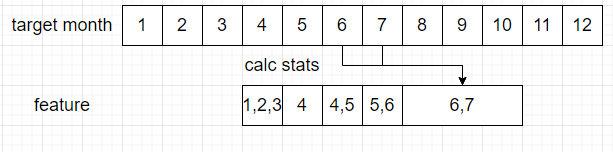  
1月と2月と3月のターゲットの値の記述統計量を4月に特徴として使う  
Use descriptive statistics of target values for January, February, and March as features in April

## Reference

Thank you for publishing a great notebook and dataset!

+ @columbia2131 [MLB lightGBM Starter Dataset&Code[en, ja]](https://www.kaggle.com/columbia2131/mlb-lightgbm-starter-dataset-code-en-ja)
+ @naotaka1128 [Creating Unnested Dataset](https://www.kaggle.com/naotaka1128/creating-unnested-dataset)
+ @mlconsult [create player descriptive stats dataset](https://www.kaggle.com/mlconsult/create-player-descriptive-stats-dataset)
+ @kaito510 [Player Salary + MLB lightGBM Starter](https://www.kaggle.com/kaito510/player-salary-mlb-lightgbm-starter)
+ @kohashi0000 [1.36 simple_LightGBM](https://www.kaggle.com/kohashi0000/1-36-simple-lightgbm)
+ @somayyehgholami, @mehrankazeminia [[Fork of] LightGBM + CatBoost + ANN 2505f2](https://www.kaggle.com/somayyehgholami/fork-of-lightgbm-catboost-ann-2505f2)
+ @nyanpn [API Emulator for debugging your code locally](https://www.kaggle.com/nyanpn/api-emulator-for-debugging-your-code-locally)

## Get env

In [ ]:
# 環境によって処理を変えるためのもの
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

## Unnest updatedfile

In [ ]:
%%python
import numpy as np
import pandas as pd
import os
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

if not os.path.isfile('./train_updated_playerBoxScores.pickle'):
    # drop playerTwitterFollowers, teamTwitterFollowers from example_test
    df = pd.read_csv(f"../input/mlb-player-digital-engagement-forecasting/train_updated.csv").dropna(axis=1,how='all')
    df = df.query("date >= 20210501")
    daily_data_nested_df_names = df.drop('date', axis = 1).columns.values.tolist()
    
    for df_name in daily_data_nested_df_names:
        date_nested_table = df[['date', df_name]]
    
        date_nested_table = (date_nested_table[
          ~pd.isna(date_nested_table[df_name])
          ].
          reset_index(drop = True)
          )
    
        daily_dfs_collection = []
    
        for date_index, date_row in date_nested_table.iterrows():
            daily_df = pd.read_json(date_row[df_name])
    
            daily_df['dailyDataDate'] = date_row['date']
    
            daily_dfs_collection = daily_dfs_collection + [daily_df]
    
        # Concatenate all daily dfs into single df for each row
        unnested_table = (pd.concat(daily_dfs_collection,
          ignore_index = True).
          # Set and reset index to move 'dailyDataDate' to front of df
          set_index('dailyDataDate').
          reset_index()
          )
        #print(f"{file}_{df_name}.pickle")
        #display(unnested_table.head(3))
        reduce_mem_usage(unnested_table).to_pickle(f"train_updated_{df_name}.pickle")
        #print('\n'*2)
    
        # Clean up tables and collection of daily data frames for this df
        del(date_nested_table, daily_dfs_collection, unnested_table)

In [ ]:
%%python
import numpy as np
import pandas as pd
from numpy import mean,std
from scipy.stats import norm
import statistics as st
import warnings

warnings.simplefilter('ignore')

def calc_probs(year, pid, df, temp, patern):
    to_append=[year, pid,'','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=2
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob) # 平均値
        std = np.std(target_prob) # 標準偏差
        median = st.median(target_prob) # 中央値
        distribution = norm(mean, std) # ノルム
        min_weight = min(target_prob) # 最小値
        max_weight = max(target_prob) # 最大値
        values = list(np.linspace(min_weight, max_weight)) # デフォルト50
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value) # 確率密度関数の頂点はlinspaceの何個目か
        to_append[z]=mean # 平均
        to_append[z+1]=median # 中央地
        to_append[z+2]=std # 標準偏差
        to_append[z+3]=min_weight # 最小値
        to_append[z+4]=max_weight # 最大値
        # よくわからないので複数パターン用意
        # ============================
        if patern == 1:
            to_append[z+5]=target_prob[max_index] # 確率密度変数の頂点
        elif patern == 2:
            to_append[z+5]=sorted(target_prob)[max_index] # 実測値
        elif patern == 3:
            to_append[z+5]=values[max_index] # 正規分布の中心
        z=z+6
    df_length = len(df)
    df.loc[df_length] = to_append
    return df

# 2021年8月以降用のスタッツを作る
targets = pd.read_pickle('./train_updated_nextDayPlayerEngagement.pickle')
targets = targets.query('20210601 <= dailyDataDate')

# CREATE DATAFRAME to store probabilities
column_names = ["year", "playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob", 
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob", 
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_prob", 
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_prob"]
player_target_probs = pd.DataFrame(columns = column_names)
year_by_probs = pd.DataFrame(columns = column_names)

years = ["2021"]
dfs = [targets]

for year, df in zip(years, dfs):
    playerId_list = df.playerId.unique().tolist()
    for pid in playerId_list:
        temp = df[df['playerId'] == pid]
        player_target_stats=calc_probs(year, pid, player_target_probs, temp, patern=3)

df = pd.read_csv('../input/mlb-features/statsdata.csv')
df8 = player_target_stats.copy()
df9 = player_target_stats.copy()
df10 = player_target_stats.copy()
df8['month'] = 8
df9['month'] = 9
df10['month'] = 10
player_target_stats = pd.concat([df, df8, df9, df10],axis=0).reset_index(drop=True)
print(player_target_stats.groupby(['year','month']).size())
player_target_stats.to_csv('player_target_stats.csv', index = False)

## Libraries

In [ ]:
# Standard library
import os, sys, gc, time, warnings, shutil, random
from pathlib import Path
from contextlib import contextmanager

# third party
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# 
import mlb

pd.set_option('display.max_rows', 500)
print(lgb.__version__)

## Config

In [ ]:
class CFG:
    seed = 29

 # Utills

In [ ]:
# Seed
def set_seed(seed: int = 29):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed(CFG.seed)

## Road

In [ ]:
INPUT_DIR = Path('../input')
UNNESTED_DIR = INPUT_DIR / 'mlb-unnested'

# non update files
# ======================================================================================
#df_players = pd.read_pickle(UNNESTED_DIR / 'players.pickle')
df_players = pd.read_csv(INPUT_DIR / 'playerscsv/NEWplayers.csv') # salarydata
df_teams = pd.read_pickle(UNNESTED_DIR / 'teams.pickle').rename(columns = {'id':'teamId'})

# update files
# ======================================================================================
df_targets = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_nextDayPlayerEngagement.pickle'),
                        pd.read_pickle('./train_updated_nextDayPlayerEngagement.pickle')],axis=0).reset_index(drop=True)
df_games = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_games.pickle'),
                      pd.read_pickle('./train_updated_games.pickle')],axis=0).reset_index(drop=True)
df_rosters = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_rosters.pickle'),
                        pd.read_pickle('./train_updated_rosters.pickle')],axis=0).reset_index(drop=True)
df_scores = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_playerBoxScores.pickle'),
                       pd.read_pickle('./train_updated_playerBoxScores.pickle')],axis=0).reset_index(drop=True)
df_team_scores = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_teamBoxScores.pickle'),
                            pd.read_pickle('./train_updated_teamBoxScores.pickle')],axis=0).reset_index(drop=True)
df_transactions = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_transactions.pickle'),
                             pd.read_pickle('./train_updated_transactions.pickle')],axis=0).reset_index(drop=True)
df_standings = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_standings.pickle'),
                          pd.read_pickle('./train_updated_standings.pickle')],axis=0).reset_index(drop=True)
df_awards = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_awards.pickle'),
                       pd.read_pickle('./train_updated_awards.pickle')],axis=0).reset_index(drop=True)
twitter_players = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_playerTwitterFollowers.pickle'),
                             pd.read_pickle('./train_updated_playerTwitterFollowers.pickle')],axis=0).reset_index(drop=True)
twitter_team = pd.concat([pd.read_pickle(UNNESTED_DIR / 'train_teamTwitterFollowers.pickle'),
                          pd.read_pickle('./train_updated_teamTwitterFollowers.pickle')],axis=0).reset_index(drop=True)

# ネストを外すときnanの場合があり、そのときは同じ形のdataframeを作る必要がある
columns_dict = {'games': df_games.columns,
                'rosters': df_rosters.columns,
                'playerBoxScores': df_scores.columns,
                'teamBoxScores': df_team_scores.columns,
                'transactions': df_transactions.columns,
                'standings': df_standings.columns,
                'awards': df_awards.columns,
                'playerTwitterFollowers':twitter_players.columns,
                'teamTwitterFollowers':twitter_team.columns}

In [ ]:
# Setting COL list
# ======================================================================================
# COL_PLAYERS = ['playerId', 'primaryPositionCode', 'american']
COL_PLAYERS = ['playerId', 'primaryPositionName', 'american', 'salary']
COL_TEAMS = ['teamId', 'leagueId', 'divisionId']

COL_ROSTERS = ['dailyDataDate', 'playerId', 'teamId', 'statusCode']
COL_STANDINGS = ['dailyDataDate', 'teamId', 'wins', 'losses', 'lastTenWins','lastTenLosses']
COL_SCORES = [i for i in df_scores.columns.to_list() if i not in ['gamePk','gameDate','gameTimeUTC','teamId','teamName','playerName','positionName','positionType','jerseyNum', 'battingOrder']]

COL_STANDINGS = ['wins', 'losses', 'lastTenWins','lastTenLosses']


tmp_feature_set = set(COL_PLAYERS + COL_ROSTERS + COL_SCORES + COL_TEAMS + COL_STANDINGS)
tmp_feature_set.discard('dailyDataDate')
tmp_feature_set.discard('gameDate')
tmp_feature_set.discard('playerId')
COL_FEATURES = list(tmp_feature_set)
COL_TARGETS = ['target1', 'target2', 'target3', 'target4']

## Preprocess & Feature engineering

In [ ]:
def FE_team_score(df_team_scores):
    """
    その日チームの勝敗、どういう勝ち方をしたかどうかの特徴量を作成する
    """
    df_team_scores = df_team_scores.rename(columns={'runsScored':'team_runsScored', 'runsPitching':'team_runsPitching'})
    # 勝ち負け
    df_team_scores.loc[df_team_scores['team_runsScored'] > df_team_scores['team_runsPitching'], ['team_win']] = 1
    # 得失点差
    df_team_scores['team_runsdiff'] = df_team_scores['team_runsScored'] - df_team_scores['team_runsPitching']
    # 完封勝ち
    df_team_scores.loc[(df_team_scores['team_runsScored'] > 0) & (df_team_scores['team_runsPitching'] == 0),['team_shutout_win']] = 1
    df_team_scores.loc[(df_team_scores['team_runsScored'] == 0) & (df_team_scores['team_runsPitching'] > 0),['team_shutout_lose']] = 1
    # fillna
    df_team_scores[['team_win','team_shutout_win','team_shutout_lose']] = df_team_scores[['team_win','team_shutout_win','team_shutout_lose']].fillna(0)
    # double header
    df_team_scores = df_team_scores.groupby(['dailyDataDate','teamId']).sum().reset_index()
    
    df_team_scores = df_team_scores[['dailyDataDate','teamId'] + COL_TEAMSCORE]
    return df_team_scores


In [ ]:
# Players
# =========================================================================================
df_players['american'] = df_players['birthCountry'].apply(lambda x:1 if x == 'USA' else 0)

# playerBoxScores 
# =========================================================================================
print(f'scores shape {df_scores.shape}')
df_scores = df_scores.groupby(['playerId','dailyDataDate']).sum().reset_index()
print(f'marged shape {df_scores.shape}')

# teamBoxScores 
# =========================================================================================
COL_TEAMSCORE = ['team_win','team_runsScored','team_runsPitching', 'team_runsdiff','team_shutout_win','team_shutout_lose']
COL_FEATURES = COL_FEATURES + COL_TEAMSCORE
print(f'team scores shape {df_team_scores.shape}')
df_team_scores = FE_team_score(df_team_scores)
print(f'team scores shape {df_team_scores.shape}')

# award 
# =========================================================================================
COL_AWARDS = ['dailyDataDate', 'playerId','num_of_award']
COL_FEATURES = COL_FEATURES + ['num_of_award']

df_awards = df_awards.groupby(["dailyDataDate","playerId"]).size().reset_index()
df_awards = df_awards.rename(columns={0: 'num_of_award'})

# transaction
# =========================================================================================
COL_TRANSACTION = ['trade']
COL_FEATURES = COL_FEATURES + COL_TRANSACTION
# 0行でも一応動く
df_transactions = df_transactions.query('typeDesc == "Trade"').dropna(subset=['playerId']).reset_index(drop=True)
df_transactions = df_transactions[['dailyDataDate','playerId']]
df_transactions = df_transactions.drop_duplicates().reset_index(drop=True)
df_transactions['trade'] = 1

# twitter
# =========================================================================================
# twitter_players = pd.read_pickle(UNNESTED_DIR / 'train_playerTwitterFollowers.pickle')
# twitter_team = pd.read_pickle(UNNESTED_DIR / 'train_teamTwitterFollowers.pickle')
# 
# df_train['yearmonth'] = df_train['dailyDataDate'].astype(str).str[:6].astype(np.int64)
# twitter_players['yearmonth'] = twitter_players['dailyDataDate'].astype(str).str[:6].astype(np.int64)
# twitter_team['yearmonth'] = twitter_team['dailyDataDate'].astype(str).str[:6].astype(np.int64)
# 
# twitter_players = twitter_players.rename(columns={'numberOfFollowers': 'numberOfFollowers_player'})
# twitter_team = twitter_team.rename(columns={'numberOfFollowers': 'numberOfFollowers_team'})
# 
# df_train = df_train.merge(twitter_players[['yearmonth', 'playerId','numberOfFollowers_player']], on=['yearmonth', 'playerId'], how='left')
# df_train = df_train.merge(twitter_team[['yearmonth', 'teamId','numberOfFollowers_team']], on=['yearmonth', 'teamId'], how='left')
# df_train[['numberOfFollowers_player','numberOfFollowers_team']] = df_train[['numberOfFollowers_player','numberOfFollowers_team']].fillna(-1)
# df_train = df_train.drop(columns='yearmonth')
# COL_TWITTER = ['numberOfFollowers_player', 'numberOfFollowers_team']
# COL_FEATURES = COL_FEATURES + COL_TWITTER


In [ ]:
%%time
print(df_targets.shape)
# Focus on regular season data
df_targets = df_targets.query('20180329 <= dailyDataDate <= 20181001 | \
                               20190328 <= dailyDataDate <= 20190929 | \
                               20200723 <= dailyDataDate <= 20200927 | \
                               20210401 <= dailyDataDate').reset_index(drop=True)

print(f"filtered{df_targets.shape}")
# Create train dataframe
df_train = df_targets.merge(df_players[COL_PLAYERS], on=['playerId'],how='left')
gc.collect()
print(df_train.shape, 'after_players')
print('--------------------------------------')

df_train = df_train.merge(df_rosters[COL_ROSTERS], on=['playerId','dailyDataDate'], how='left')
gc.collect()
print(df_train.shape, 'after_rosters')
print('--------------------------------------')

df_train = df_train.merge(df_scores[COL_SCORES], on=['playerId','dailyDataDate'], how='left')
gc.collect()
print(df_train.shape, 'after_scores')
print('--------------------------------------')

df_train = df_train.merge(df_team_scores[['dailyDataDate','teamId'] + COL_TEAMSCORE], on=['dailyDataDate','teamId'], how= 'left')
gc.collect()
print(df_train.shape, 'after_team_scores')
print('--------------------------------------')

df_train = df_train.merge(df_teams[COL_TEAMS], on=['teamId'], how='left')
gc.collect()
print(df_train.shape, 'after_teams')
print('--------------------------------------')

df_train = df_train.merge(df_standings[['dailyDataDate', 'teamId'] + COL_STANDINGS], on=['dailyDataDate','teamId'], how= 'left')
gc.collect()
print(df_train.shape, 'after_standings')
print('--------------------------------------')

df_train = df_train.merge(df_awards[COL_AWARDS], on=['dailyDataDate', 'playerId'], how='left')
gc.collect()
print(df_train.shape, 'after_awards')
print('--------------------------------------')
print(df_train.shape)

df_train = df_train.merge(df_transactions[['dailyDataDate','playerId'] + COL_TRANSACTION], on=['dailyDataDate','playerId'], how='left')
gc.collect()
print(df_train.shape, 'after_transactions')
print('--------------------------------------')
print(df_train.shape)
# print object columns
df_train.select_dtypes(include=['object']).columns

### 打点がチームの得点の何割か /What percentage of the team's score is RBI?

In [ ]:
df_train['rbi_teamruns'] = df_train['rbi'] / df_train['team_runsScored']
COL_FEATURES = COL_FEATURES + ['rbi_teamruns']

### 記述統計量の追加 / add stats

In [ ]:
if os.path.isfile('./player_target_stats.csv'):
    df_stats = pd.read_csv('./player_target_stats.csv')
    df_train['year'] = df_train['dailyDataDate'].astype(str).str[:4].astype(np.int64)
    df_train['month'] = df_train['dailyDataDate'].astype(str).str[4:6].astype(np.int64)
    df_train = df_train.merge(df_stats, on=['year','month', 'playerId'], how='left')
    df_train = df_train.drop(columns=['year', 'month'])
    df_stats = df_stats.drop(columns=['month'])
else:
    df_stats = pd.read_csv('../input/mlb-features/player_target_stats_pattern3.csv')
    df_train['year'] = df_train['dailyDataDate'].astype(str).str[:4].astype(np.int64)
    df_train = df_train.merge(df_stats, on=['year', 'playerId'], how='left')
    df_train = df_train.drop(columns='year')

stas_feat = df_stats.columns.to_list()[2:]
COL_FEATURES = COL_FEATURES + stas_feat

### 人気選手がホームランを打ったか特徴量 / Whether a popular player hit a home run

In [ ]:
HR_dict = {545361:'HR_Trout', 592450:'HR_Judge', 592885:'HR_Yelich', 660271:'HR_Ohtani', 660670:'HR_Acuna'}
def get_HR(df):
    COL_HR = []
    HR_list = [pd.DataFrame({'dailyDataDate' : [0,0,0,0,0],
              'playerId': [545361, 592450, 592885, 660271, 660670],
              'homeRuns':[0,0,0,0,0]})]
    for key in HR_dict:
        df_tmp = df.query(f"playerId == {key} & homeRuns > 0")[['dailyDataDate','playerId', 'homeRuns']]
        HR_list.append(df_tmp)
        COL_HR.append(HR_dict[key])
    df_HR = pd.concat(HR_list, axis=0)
    df_HR = df_HR.groupby(['dailyDataDate','playerId']).sum().reset_index()
    df_HR = df_HR.pivot(index='dailyDataDate', columns='playerId', values='homeRuns')
    df_HR = df_HR.rename(columns=HR_dict)
    return df_HR, COL_HR
df_HR, COL_HR = get_HR(df_train.copy())
df_train = df_train.merge(df_HR, on=['dailyDataDate'], how='left')
df_train[COL_HR] = df_train[COL_HR].fillna(0)
# 特徴量配列に追記
COL_FEATURES = COL_FEATURES + COL_HR

In [ ]:
# label encoding
player2num = {c: i for i, c in enumerate(df_train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(df_train['primaryPositionName'].unique())} # salaryデータ
teamid2num = {c: i for i, c in enumerate(df_train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(df_train['statusCode'].unique())}
leagueId2num = {c: i for i, c in enumerate(df_train['leagueId'].unique())}
divisionId2num = {c: i for i, c in enumerate(df_train['divisionId'].unique())}

df_train['label_playerId'] = df_train['playerId'].map(player2num)
df_train['primaryPositionName'] = df_train['primaryPositionName'].map(position2num)
df_train['teamId'] = df_train['teamId'].map(teamid2num)
df_train['statusCode'] = df_train['statusCode'].map(status2num)
df_train['leagueId'] = df_train['leagueId'].map(leagueId2num)
df_train['divisionId'] = df_train['divisionId'].map(divisionId2num)
COL_FEATURES = COL_FEATURES + ['label_playerId']

### aggregate　NaN

In [ ]:
df_train.isnull().sum()

In [ ]:
set(df_train.columns).difference(set(COL_FEATURES))

## CV Split

In [ ]:
# save
import pickle
df_train.to_pickle('df_train.pickle')
with open('COL_FEATURES.pickle', mode='wb') as f:
        pickle.dump(COL_FEATURES,f)

In [ ]:
train_X = df_train.query("dailyDataDate > 20210101")[COL_FEATURES]
train_y = df_train.query("dailyDataDate > 20210101")[COL_TARGETS]
#train_X = df_train[COL_FEATURES]
#train_y = df_train[COL_TARGETS]

_index = (df_train['dailyDataDate'] < 20210601)
X_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
X_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)
print(X_train.shape, X_valid.shape)

## model

In [ ]:
def fit_lgbm(X_train, y_train, X_valid, y_valid,  params: dict=None, seed=42,verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    params["seed"] = seed
    model = lgb.train(params,
                      lgb_train,
                      #categorical_feature=['statusCode', 'primaryPositionCode'],
                      valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=100,
                      num_boost_round=10000,
                      early_stopping_rounds=100
                     )
    oof_pred = model.predict(X_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    _ = lgb.plot_importance(model,max_num_features=20,figsize=(10,10))
    return oof_pred, model, score

In [ ]:
# training lightgbm
params1 = {'objective':'mae',
           'reg_alpha': 0.14947461820098767, 
           'reg_lambda': 0.10185644384043743, 
           'n_estimators': 3633, 
           'learning_rate': 0.08046301304430488, 
           'num_leaves': 674, 
           'feature_fraction': 0.9101240539122566, 
           'bagging_fraction': 0.9884451442950513, 
           'bagging_freq': 8, 
           'min_child_samples': 51}

params2 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 80,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 22}

params3 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 10000,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 100
           }

params4 = {'objective':'mae',
           'reg_alpha': 0.016468100279441976, 
           'reg_lambda': 0.09128335764019105, 
           'n_estimators': 9868, 
           'learning_rate': 0.10528150510326864, 
           'num_leaves': 157, 
           'feature_fraction': 0.5419185713426886, 
           'bagging_fraction': 0.2637405128936662, 
           'bagging_freq': 19, 
           'min_child_samples': 71}



oof1_1, model1_1, score1_1 = fit_lgbm(
    X_train, y_train['target1'],
    X_valid, y_valid['target1'],
    params1,29
)
oof1_2, model1_2, score1_2 = fit_lgbm(
    X_train, y_train['target1'],
    X_valid, y_valid['target1'],
    params1,42
)
oof2_1, model2_1, score2_1 = fit_lgbm(
    X_train, y_train['target2'],
    X_valid, y_valid['target2'],
    params2,29
)
oof2_2, model2_2, score2_2 = fit_lgbm(
    X_train, y_train['target2'],
    X_valid, y_valid['target2'],
    params2,42
)
oof3_1, model3_1, score3_1 = fit_lgbm(
    X_train, y_train['target3'],
    X_valid, y_valid['target3'],
    params3,29
)
oof3_2, model3_2, score3_2 = fit_lgbm(
    X_train, y_train['target3'],
    X_valid, y_valid['target3'],
    params3,42
)
oof4_1, model4_1, score4_1 = fit_lgbm(
    X_train, y_train['target4'],
    X_valid, y_valid['target4'],
    params4,29
)
oof4_2, model4_2, score4_2 = fit_lgbm(
    X_train, y_train['target4'],
    X_valid, y_valid['target4'],
    params4,42
)
score1 = (score1_1+score2_1+score3_1+score4_1) / 4
score2 = (score1_2+score2_2+score3_2+score4_2) / 4
print(f'score1: {score1}')
print(f'score2: {score2}')

In [ ]:
score1 = mean_absolute_error((oof1_1+oof1_2)/2, y_valid['target1'])
score2 = mean_absolute_error((oof2_1+oof2_2)/2, y_valid['target2'])
score3 = mean_absolute_error((oof3_1+oof3_2)/2, y_valid['target3'])
score4 = mean_absolute_error((oof4_1+oof4_2)/2, y_valid['target4'])
score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

## train on alldata

In [ ]:
def fit_lgbm_all(X_train, y_train, params: dict=None, seed=42, verbose=100):
    lgb_train = lgb.Dataset(X_train, y_train)
    params["seed"] = seed
    model = lgb.train(params,lgb_train)
    return model

In [ ]:
train_X = df_train.query("dailyDataDate > 20210101")[COL_FEATURES]
train_y = df_train.query("dailyDataDate > 20210101")[COL_TARGETS]
print(train_X.shape, train_y.shape)
best_param1 = dict(params1)
best_param1['num_iterations'] = int(model1_1.best_iteration*1.1)
model1_1 = fit_lgbm_all(train_X, train_y['target1'], best_param1, 29)
best_param1['num_iterations'] = int(model1_2.best_iteration*1.1)
model1_2 = fit_lgbm_all(train_X, train_y['target1'], best_param1, 42)

best_param2 = dict(params2)
best_param2['num_iterations'] = int(model2_1.best_iteration*1.1)
model2_1 = fit_lgbm_all(train_X, train_y['target2'], best_param2, 29)
best_param2['num_iterations'] = int(model2_2.best_iteration*1.1)
model2_2 = fit_lgbm_all(train_X, train_y['target2'], best_param2, 42)

best_param3 = dict(params3)
best_param3['num_iterations'] = int(model3_1.best_iteration*1.1)
model3_1 = fit_lgbm_all(train_X, train_y['target3'], best_param3, 29)
best_param3['num_iterations'] = int(model3_2.best_iteration*1.1)
model3_2 = fit_lgbm_all(train_X, train_y['target3'], best_param3, 42)

best_param4 = dict(params4)
best_param4['num_iterations'] = int(model4_1.best_iteration*1.1)
model4_1 = fit_lgbm_all(train_X, train_y['target4'], best_param4, 29)
best_param4['num_iterations'] = int(model4_2.best_iteration*1.1)
model4_2 = fit_lgbm_all(train_X, train_y['target4'], best_param4, 42)

In [ ]:
del(train_X, train_y, df_games, df_targets)
gc.collect()

## Inference & emulator

In [ ]:
import os
import warnings
from typing import Optional, Tuple


class Environment:
    def __init__(self,
                 data_dir: str,
                 eval_start_day: int,
                 eval_end_day: Optional[int],
                 use_updated: bool,
                 multiple_days_per_iter: bool):
        warnings.warn('this is mock module for mlb')

        postfix = '_updated' if use_updated else ''
        
        # recommend to replace this with pickle, feather etc to speedup preparing data
        df_train = pd.read_pickle(os.path.join(data_dir, f'train{postfix}.pkl'))

        players = pd.read_pickle('../input/mlb-unnested/players.pickle')

        self.players = players[players['playerForTestSetAndFuturePreds'] == True]['playerId'].astype(str)
        if eval_end_day is not None:
            self.df_train = df_train.set_index('date').loc[eval_start_day:eval_end_day]
        else:
            self.df_train = df_train.set_index('date').loc[eval_start_day:]
        self.date = self.df_train.index.values
        self.n_rows = len(self.df_train)
        self.multiple_days_per_iter = multiple_days_per_iter

        assert self.n_rows > 0, 'no data to emulate'

    def predict(self, df: pd.DataFrame) -> None:
        # if you want to emulate public LB, store your prediction here and calculate MAE
        pass

    def iter_test(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if self.multiple_days_per_iter:
            for i in range(self.n_rows // 2):
                date1 = self.date[2 * i]
                date2 = self.date[2 * i + 1]
                sample_sub1 = self._make_sample_sub(date1)
                sample_sub2 = self._make_sample_sub(date2)
                sample_sub = pd.concat([sample_sub1, sample_sub2]).reset_index(drop=True)
                df = self.df_train.loc[date1:date2]

                yield df, sample_sub.set_index('date')
        else:
            for i in range(self.n_rows):
                date = self.date[i]
                sample_sub = self._make_sample_sub(date)
                df = self.df_train.loc[date:date]

                yield df, sample_sub.set_index('date')

    def _make_sample_sub(self, date: int) -> pd.DataFrame:
        next_day = (pd.to_datetime(date, format='%Y%m%d') + pd.to_timedelta(1, 'd')).strftime('%Y%m%d')
        sample_sub = pd.DataFrame()
        sample_sub['date_playerId'] = next_day + '_' + self.players
        sample_sub['target1'] = 0
        sample_sub['target2'] = 0
        sample_sub['target3'] = 0
        sample_sub['target4'] = 0
        sample_sub['date'] = date
        return sample_sub
    
class MLBEmulator:
    def __init__(self,
                 data_dir: str = '../input/mlb-features',
                 eval_start_day: int = 20210401,
                 eval_end_day: Optional[int] = 20210430,
                 use_updated: bool = True,
                 multiple_days_per_iter: bool = False):
        self.data_dir = data_dir
        self.eval_start_day = eval_start_day
        self.eval_end_day = eval_end_day
        self.use_updated = use_updated
        self.multiple_days_per_iter = multiple_days_per_iter

    def make_env(self) -> Environment:
        return Environment(self.data_dir,
                           self.eval_start_day,
                           self.eval_end_day,
                           self.use_updated,
                           self.multiple_days_per_iter)

In [ ]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_unnested_data(df: pd.DataFrame, sample_prediction_df: pd.DataFrame):
    # ['games', 'rosters', 'playerBoxScores', 'teamBoxScores', 'transactions', 'standings', 'awards', 'events']
    #daily_data_nested_df_names = df.drop('date', axis = 1).columns.values.tolist()
    daily_data_nested_df_names =['games', 'rosters', 'playerBoxScores', 'teamBoxScores','awards','transactions','standings']
    dfs_dict = {}
    for df_name in daily_data_nested_df_names:
        #print(df_name)
        date_nested_table = df[['date', df_name]]
        
        date_nested_table = (date_nested_table[
            ~pd.isna(date_nested_table[df_name])
            ].reset_index(drop = True))
        #Dealing with missing values
        #print(len(date_nested_table))
        daily_dfs_collection = []
        
        if len(date_nested_table) == 0:
            daily_df = pd.DataFrame({'dailyDataDate':sample_prediction_df['dailyDataDate'],
                                     'playerId': sample_prediction_df['playerId']})
            for col in columns_dict[df_name]:
                if col in ['dailyDataDate', 'playerId']: continue
                daily_df[col] = np.nan
            daily_dfs_collection = daily_dfs_collection + [daily_df]
        else:
            for date_index, date_row in date_nested_table.iterrows():
                daily_df = pd.read_json(date_row[df_name])
                daily_df['dailyDataDate'] = date_row['date']
                daily_dfs_collection = daily_dfs_collection + [daily_df]
            
        unnested_table = (pd.concat(daily_dfs_collection,
            ignore_index = True).
            # Set and reset index to move 'dailyDataDate' to front of df
            set_index('dailyDataDate').
            reset_index()
            )
        reduce_mem_usage(unnested_table).to_pickle(f"test_{df_name}.pickle")
        dfs_dict[df_name] = reduce_mem_usage(unnested_table)
        del(date_nested_table, daily_dfs_collection, unnested_table)
    return dfs_dict

In [ ]:
def inference(test_df, sample_prediction_df):
    dfs_dict = get_unnested_data(test_df, sample_prediction_df)
    df_test_rosters = dfs_dict['rosters']
    df_test_games = dfs_dict['games']
    df_test_scores = dfs_dict['playerBoxScores']
    df_test_team_scores = dfs_dict['teamBoxScores']
    df_test_awards = dfs_dict['awards']
    df_test_transactions = dfs_dict['transactions']
    df_test_standings = dfs_dict['standings']

    # FE
    # ==========================================
    df_test_team_scores = FE_team_score(df_test_team_scores)

    df_test_scores = df_test_scores.groupby(['playerId','dailyDataDate']).sum().reset_index()
    #df_test_scores = df_test_scores.drop_duplicates(subset=['playerId','dailyDataDate']).reset_index()
    df_test = sample_prediction_df[['playerId','dailyDataDate']].copy()
    df_test = df_test.merge(df_players[COL_PLAYERS], on=['playerId'],how='left')
    df_test = df_test.merge(df_test_rosters[COL_ROSTERS], on=['playerId','dailyDataDate'], how='left')
    df_test = df_test.merge(df_test_scores[COL_SCORES], on=['playerId','dailyDataDate'], how='left')
    df_test = df_test.merge(df_test_team_scores[['dailyDataDate','teamId'] + COL_TEAMSCORE], on=['dailyDataDate','teamId'], how= 'left')
    df_test = df_test.merge(df_teams[COL_TEAMS],on=['teamId'], how='left')
    
    #standings
    if test_df['standings'].iloc[0] == test_df['standings'].iloc[0]: # nanだとelseに行く
        df_test = df_test.merge(df_test_standings[['dailyDataDate', 'teamId'] + COL_STANDINGS], on=['dailyDataDate','teamId'], how= 'left')
    else:
        df_test[COL_STANDINGS] = np.nan
    # awards
    df_test_awards = df_test_awards.dropna(how='any')
    if len(df_test_awards) > 0:
        df_test_awards = df_test_awards.groupby(["dailyDataDate","playerId"]).size().reset_index()
        df_test_awards = df_test_awards.rename(columns={0: 'num_of_award'})
        df_test = df_test.merge(df_test_awards[COL_AWARDS], on=['dailyDataDate', 'playerId'], how='left')
    else:
        df_test['num_of_award'] = np.nan
        
    # transaction
    df_test_transactions = df_test_transactions.query('typeDesc == "Trade"').dropna(subset=['playerId']).reset_index(drop=True)
    if len(df_test_transactions) > 0:
        df_test_transactions = df_test_transactions[["dailyDataDate","playerId"]]
        df_test_transactions = df_test_transactions.drop_duplicates().reset_index(drop=True)
        df_test_transactions['trade'] = 1
        df_test = df_test.merge(df_test_transactions[["dailyDataDate","playerId"] + COL_TRANSACTION], on=["dailyDataDate","playerId"], how='left')
    else:
        df_test['trade'] = 0
    # rbiの割合
    df_test['rbi_teamruns'] = df_test['rbi'] / df_train['team_runsScored']
    
    # 記述統計
    if os.path.isfile('./player_target_stats.csv'):
        df_stats = pd.read_csv('./player_target_stats.csv')
        df_test['year'] = df_test['dailyDataDate'].astype(str).str[:4].astype(np.int64)
        df_test['month'] = df_test['dailyDataDate'].astype(str).str[4:6].astype(np.int64)
        df_test = df_test.merge(df_stats, on=['year','month', 'playerId'], how='left')
        df_test = df_test.drop(columns=['year', 'month'])
    else:
        df_stats = pd.read_csv('../input/mlb-features/player_target_stats_pattern3.csv')
        df_test['year'] = df_test['dailyDataDate'].astype(str).str[:4].astype(np.int64)
        df_test = df_test.merge(df_stats, on=['year', 'playerId'], how='left')
        df_test = df_test.drop(columns='year')
    
    # HR
    df_HR, _ = get_HR(df_test.copy())
    if len(df_HR) > 0:
        df_test = df_test.merge(df_HR, on=['dailyDataDate'], how='left')
        df_test[COL_HR] = df_test[COL_HR].fillna(0)
    else:
        df_test[COL_HR] = 0
    
    # Label Encoding
    df_test['label_playerId'] = df_test['playerId'].map(player2num)
    df_test['primaryPositionName'] = df_test['primaryPositionName'].map(position2num)
    df_test['teamId'] = df_test['teamId'].map(teamid2num)
    df_test['statusCode'] = df_test['statusCode'].map(status2num)
    df_test['leagueId'] = df_test['leagueId'].map(leagueId2num)
    df_test['divisionId'] = df_test['divisionId'].map(divisionId2num)
    
    test_X = df_test[COL_FEATURES]
    # predict
    pred1_1 = model1_1.predict(test_X)
    pred2_1 = model2_1.predict(test_X)
    pred3_1 = model3_1.predict(test_X)
    pred4_1 = model4_1.predict(test_X)
    pred1_2 = model1_2.predict(test_X)
    pred2_2 = model2_2.predict(test_X)
    pred3_2 = model3_2.predict(test_X)
    pred4_2 = model4_2.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip((pred1_1 + pred1_2)/2, 0, 100)
    sample_prediction_df['target2'] = np.clip((pred2_1 + pred2_2)/2, 0, 100)
    sample_prediction_df['target3'] = np.clip((pred3_1 + pred3_2)/2, 0, 100)
    sample_prediction_df['target4'] = np.clip((pred4_1 + pred4_2)/2, 0, 100)
    
    #　大谷
    if df_test["HR_Ohtani"][0] > 0:
        sample_prediction_df.loc[sample_prediction_df['playerId'] ==660271, ['target1', 'target2', 'target3', 'target4']] = 100   
    
    sample_prediction_df = sample_prediction_df.fillna(0.)
    del sample_prediction_df['playerId'], sample_prediction_df['dailyDataDate']
    
    return sample_prediction_df
    #env.predict(sample_prediction_df)

In [ ]:
emulation_mode = False

if emulation_mode:
    mlb = MLBEmulator(eval_start_day=20210501, eval_end_day=20210531)
else:
    import mlb
env = mlb.make_env()# initialize the environment

iter_test = env.iter_test() # iterator which loops over each date in test set

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    #sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    sample_prediction_df = sample_prediction_df.reset_index().rename(columns={'date':'dailyDataDate'})
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    
    # ==========================================
    test_df = test_df.reset_index().rename(columns={'index':'date'})
    
    sample_prediction_df = inference(test_df, sample_prediction_df)
    
    env.predict(sample_prediction_df)

## The emulator

score1.2487188781157268

In [ ]:
mlb = MLBEmulator(eval_start_day=20210501, eval_end_day=20210531)
env = mlb.make_env()# initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set
col = ['target1_', 'target2_', 'target3_', 'target4_']
oof_preds = []
scores=0
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    #sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    sample_prediction_df = sample_prediction_df.reset_index().rename(columns={'date':'dailyDataDate'})
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    
    # ==========================================
    test_df = test_df.reset_index().rename(columns={'index':'date'})
    sample_prediction_df = inference(test_df, sample_prediction_df)
    
    #env.predict(sample_prediction_df)
    
    targets = pd.read_json(test_df['nextDayPlayerEngagement'][0])
    targets.columns = ['engagementMetricsDate', 'playerId'] + col
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    oof_pred = sample_prediction_df.merge(targets[['playerId'] + col], on='playerId', how='left')
    # mae by day
    score = mean_absolute_error(oof_pred[['target1', 'target2', 'target3', 'target4']].values, oof_pred[col].values)
    print(f"{score}")
    scores += score
    oof_preds.append(oof_pred)

oof_df = pd.concat(oof_preds,axis=0).reset_index(drop=True)
print('=*'*30)
print(f"score{scores/len(oof_preds)}")

### nan test

In [ ]:
# _test_df = [pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv').query("date == 20210426"),
#             pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv').query("date == 20210427"),
#             pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv').query("date == 20210428"),
#             pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv').query("date == 20210429"),
#             pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv').query("date == 20210430")]
# sample = [pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv').query('date == 20210426').set_index('date'),
#           pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv').query('date == 20210427').set_index('date'),
#           pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv').query('date == 20210428').set_index('date'),
#           pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv').query('date == 20210429').set_index('date'),
#           pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv').query('date == 20210430').set_index('date')]
# # nanのテスト
# _test_df[0].iloc[:,1:] = np.nan
# pred = []
# for i in range(5):
#     test_df = _test_df[i]
#     sample_prediction_df = sample[i]
#     #sample_prediction_df = sample_prediction_df.reset_index(drop=True)
#     sample_prediction_df = sample_prediction_df.reset_index().rename(columns={'date':'dailyDataDate'})
#     sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
#                                         .map(lambda x: int(x.split('_')[1]))

#     sample_prediction_df = inference(test_df, sample_prediction_df)
#     pred.append(sample_prediction_df)
    
#     #dfs_dict = get_unnested_data(test_df, sample_prediction_df)
# sub = pd.concat(pred, axis=0)